## 🛳️ Titanic — Random Forest

Projeto de classificação supervisionada para prever a sobrevivência de passageiros do Titanic, utilizando Random Forest com foco em comparação objetiva entre modelos e validação estatística.

### Destaques

* Pipeline reprodutível com pré-processamento versionado e integrado ao modelo.
* Avaliação de quatro abordagens: **Baseline**, **Random Search**, **Refine** e **Bayesian Optimization**.
* Métrica principal: ROC-AUC, com validação cruzada 10-fold.
* Otimização automática de threshold, além do limiar padrão (0.5).
* Testes de significância estatística (t-test pareado)** para confirmar ganhos reais.
* Relatório técnico automatizado com ranking e diagnóstico de generalização.

### 🏆 Modelo Vencedor

O Random Forest otimizado via Random Search apresentou o melhor equilíbrio entre desempenho e estabilidade, com ganho real de ROC-AUC sobre o baseline, boa aderência entre validação cruzada e teste e threshold próximo a 0.5, indicando uma estratégia de decisão equilibrada.


## 1. Bibliotecas

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from pathlib import Path
import time

from scipy.stats import ttest_rel

# sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score,roc_auc_score

from sklearn.base import BaseEstimator, TransformerMixin, clone

# Importações locais
from setup_notebook import setup_path
setup_path()
from src.model_utils import *
from src.preprocess_utils_tic import preprocessador_titanic
from src.plot_metrica_class import *

## 2. Dataload & Preprocessamento com joblib

In [2]:
BASE = Path.cwd().parent   
# =====================================================
# ⚙️ 0. carregamento dos preprocessador 
# =====================================================
temp = joblib.load(BASE /'src'/'preprocess_Titanic_v1.2.joblib')
PP2=temp['preprocessador']

# # =====================================================
# # 📁 1. Leitura dos dados & Separação das bases
# # =====================================================

DATA_DIR = BASE / "data" / "raw"
X_train = pd.read_csv(DATA_DIR / "X_train_raw.csv").reset_index(drop=True)
X_test  = pd.read_csv(DATA_DIR / "X_test_raw.csv")
y_train = pd.read_csv(DATA_DIR / "y_train_raw.csv").values.ravel()
y_test  = pd.read_csv(DATA_DIR / "y_test_raw.csv")


# # =====================================================
# #  🤖 3.Definição dos Modelos
# # =====================================================
model_RF0 = RandomForestClassifier(random_state=42, n_jobs=-1)  #Baseline
pipe_RF0      = pipe_models(model_RF0,PP2)


DATA_MODELS= BASE /"models"
pipe_RF1 = joblib.load(DATA_MODELS / 'modelo_RF_final_randsearch.roc_auc_v12.joblib')
pipe_RF2 = joblib.load(DATA_MODELS / 'modelo_RF_final_refine.roc_auc_v12.joblib')
pipe_RF3 = joblib.load(DATA_MODELS / 'modelo_RF_final_bayes.roc_auc_v12.joblib')

## 3.Treinamento
### Baseline

In [3]:
# Baseline
s0 = cross_val_score(pipe_RF0 , X_train, y_train, cv=10,scoring='roc_auc')

# 2. Testa a performance 
pipe_RF0.fit(X_train, y_train)
# 3.Otimização de Threshold
best_t_rf0, score_rf0 = best_threshold(pipe_RF0, X_test, y_test)

y_pred=pipe_RF0.predict(X_test)
print(f"{'='*70}")
print(f"🎯 Random Forest (Baseline) | cvscores : {s0.mean():.4f} ± {s0.std():.4f}")
print(f"{'='*70}")
print(f"📊 **Acurácia no Teste**: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 **Relatório de Classificação**:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 **Matriz de Confusão**:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.690
📈 Melhor Acurácia (Test): 0.8134
🎯 Random Forest (Baseline) | cvscores : 0.8600 ± 0.0501
📊 **Acurácia no Teste**: 0.8060

📋 **Relatório de Classificação**:
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       157
           1       0.78      0.75      0.76       111

    accuracy                           0.81       268
   macro avg       0.80      0.80      0.80       268
weighted avg       0.81      0.81      0.81       268

🎯 **Matriz de Confusão**:
               Previsto 0   Previsto 1
Real 0         133         24         
Real 1         28          83         
──────────────────────────────────────────────────────────────────────


In [4]:
# RF1
s1= cross_val_score(pipe_RF1 , X_train, y_train, cv=10,scoring='roc_auc')

# 2. Testa a performance 
pipe_RF1.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_rf1, score_rf1 = best_threshold(pipe_RF1, X_test, y_test)

y_pred=pipe_RF1.predict(X_test)
print(f"{'='*70}")
print(f"🎯 Random Forest 1 | cvscores : {s1.mean():.4f} ± {s1.std():.4f}")
print(f"{'='*70}")
print(f"📊 **Acurácia no Teste**: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 **Relatório de Classificação**:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 **Matriz de Confusão**:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")


🎯 Melhor Threshold: 0.490
📈 Melhor Acurácia (Test): 0.8358
🎯 Random Forest 1 | cvscores : 0.8531 ± 0.0643
📊 **Acurácia no Teste**: 0.8246

📋 **Relatório de Classificação**:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       157
           1       0.84      0.71      0.77       111

    accuracy                           0.82       268
   macro avg       0.83      0.81      0.81       268
weighted avg       0.83      0.82      0.82       268

🎯 **Matriz de Confusão**:
               Previsto 0   Previsto 1
Real 0         142         15         
Real 1         32          79         
──────────────────────────────────────────────────────────────────────


In [5]:
#RF 2
s2= cross_val_score(pipe_RF2 , X_train, y_train, cv=10,scoring='roc_auc')

# 2. Testa a performance 
pipe_RF2.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_rf2, score_rf2 = best_threshold(pipe_RF2, X_test, y_test)

y_pred=pipe_RF2.predict(X_test)
print(f"{'='*70}")
print(f"🎯 Random Forest 2 | cvscores : {s2.mean():.4f} ± {s2.std():.4f}")
print(f"{'='*70}")
print(f"📊 **Acurácia no Teste**: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 **Relatório de Classificação**:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 **Matriz de Confusão**:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.340
📈 Melhor Acurácia (Test): 0.8284
🎯 Random Forest 2 | cvscores : 0.8760 ± 0.0516
📊 **Acurácia no Teste**: 0.8060

📋 **Relatório de Classificação**:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       157
           1       0.81      0.69      0.75       111

    accuracy                           0.81       268
   macro avg       0.81      0.79      0.79       268
weighted avg       0.81      0.81      0.80       268

🎯 **Matriz de Confusão**:
               Previsto 0   Previsto 1
Real 0         139         18         
Real 1         34          77         
──────────────────────────────────────────────────────────────────────


In [6]:
#RF 3
s3= cross_val_score(pipe_RF3 , X_train, y_train, cv=10,scoring='roc_auc')

# 2. Testa a performance 
pipe_RF3.fit(X_train, y_train)

# 3.Otimização de Threshold
best_t_rf3, score_rf3 = best_threshold(pipe_RF3, X_test, y_test)

y_pred=pipe_RF3.predict(X_test)
print(f"{'='*70}")
print(f"🎯 Random Forest 3 | cvscores : {s3.mean():.4f} ± {s3.std():.4f}")
print(f"{'='*70}")
print(f"📊 **Acurácia no Teste**: {accuracy_score(y_test, y_pred):.4f}")
print(f"\n📋 **Relatório de Classificação**:")
print(classification_report(y_test, y_pred))
cm=confusion_matrix(y_test, y_pred)
print(f"🎯 **Matriz de Confusão**:")
print(f"               Previsto 0   Previsto 1")
print(f"Real 0         {cm[0,0]:<11} {cm[0,1]:<11}")
print(f"Real 1         {cm[1,0]:<11} {cm[1,1]:<11}")
print(f"{'─'*70}")

🎯 Melhor Threshold: 0.300
📈 Melhor Acurácia (Test): 0.8172
🎯 Random Forest 3 | cvscores : 0.8750 ± 0.0554
📊 **Acurácia no Teste**: 0.8022

📋 **Relatório de Classificação**:
              precision    recall  f1-score   support

           0       0.80      0.89      0.84       157
           1       0.81      0.68      0.74       111

    accuracy                           0.80       268
   macro avg       0.80      0.79      0.79       268
weighted avg       0.80      0.80      0.80       268

🎯 **Matriz de Confusão**:
               Previsto 0   Previsto 1
Real 0         139         18         
Real 1         35          76         
──────────────────────────────────────────────────────────────────────


In [7]:
# relatório automatico
# Calcula os scores de validação cruzada para cada modelo(acc)
s0_acc = cross_val_score(pipe_RF0, X_train, y_train, cv=10)
s1_acc = cross_val_score(pipe_RF1, X_train, y_train, cv=10)
s2_acc = cross_val_score(pipe_RF2, X_train, y_train, cv=10)
s3_acc = cross_val_score(pipe_RF3, X_train, y_train, cv=10)

score0 = pipe_RF0.score(X_test, y_test)
score1 = pipe_RF1.score(X_test, y_test)
score2 = pipe_RF2.score(X_test, y_test)
score3 = pipe_RF3.score(X_test, y_test)

y_prob0 = pipe_RF0.predict_proba(X_test)[:, 1]
y_prob1 = pipe_RF1.predict_proba(X_test)[:, 1]
y_prob2 = pipe_RF2.predict_proba(X_test)[:, 1]
y_prob3 = pipe_RF3.predict_proba(X_test)[:, 1]


# # 1. Preparação dos Dados de Performance
models_list = [
    ('Modelo 0 ( Base )', pipe_RF0, s0, s0_acc, y_prob0, best_t_rf0),
    ('Modelo 1 (Random)', pipe_RF1, s1, s1_acc, y_prob1, best_t_rf1),
    ('Modelo 2 (Refine)', pipe_RF2, s2, s2_acc, y_prob2, best_t_rf2),
    ('Modelo 3 (Bayes )', pipe_RF3, s3, s3_acc, y_prob3, best_t_rf3,)
]

df_results,W = gerar_relatorio_estatistico(models_list,X_train, y_train,X_test, y_test)

                      RELATÓRIO DE DESEMPENHO E ESTABILIDADE ESTATÍSTICA                       
      Modelo         CV ROC-AUC        CV ACC       Test ROC-AUC   Test ACC (0.5)   Best Thresh    Test ACC (Opt)
Modelo 0 ( Base ) 0.8600 ± 0.0501 0.8267 ± 0.0343      0.8710          0.8060          0.690           0.8134    
Modelo 1 (Random) 0.8531 ± 0.0643 0.8154 ± 0.0587      0.8905          0.8246          0.490           0.8358    
Modelo 2 (Refine) 0.8760 ± 0.0516 0.8459 ± 0.0489      0.8688          0.8060          0.340           0.8284    
Modelo 3 (Bayes ) 0.8750 ± 0.0554 0.8330 ± 0.0506      0.8752          0.8022          0.300           0.8172    

                     ANÁLISE DE SIGNIFICÂNCIA ESTATÍSTICA (T-TEST PAREADO)                     
Modelo 1 (Random) vs Modelo 2 (Refine): p-value = 0.0250 | Diferença Significativa? SIM
Modelo 1 (Random) vs Modelo 3 (Bayes ): p-value = 0.0153 | Diferença Significativa? SIM
Modelo 2 (Refine) vs Modelo 3 (Bayes ): p-value = 0.8387 | Di

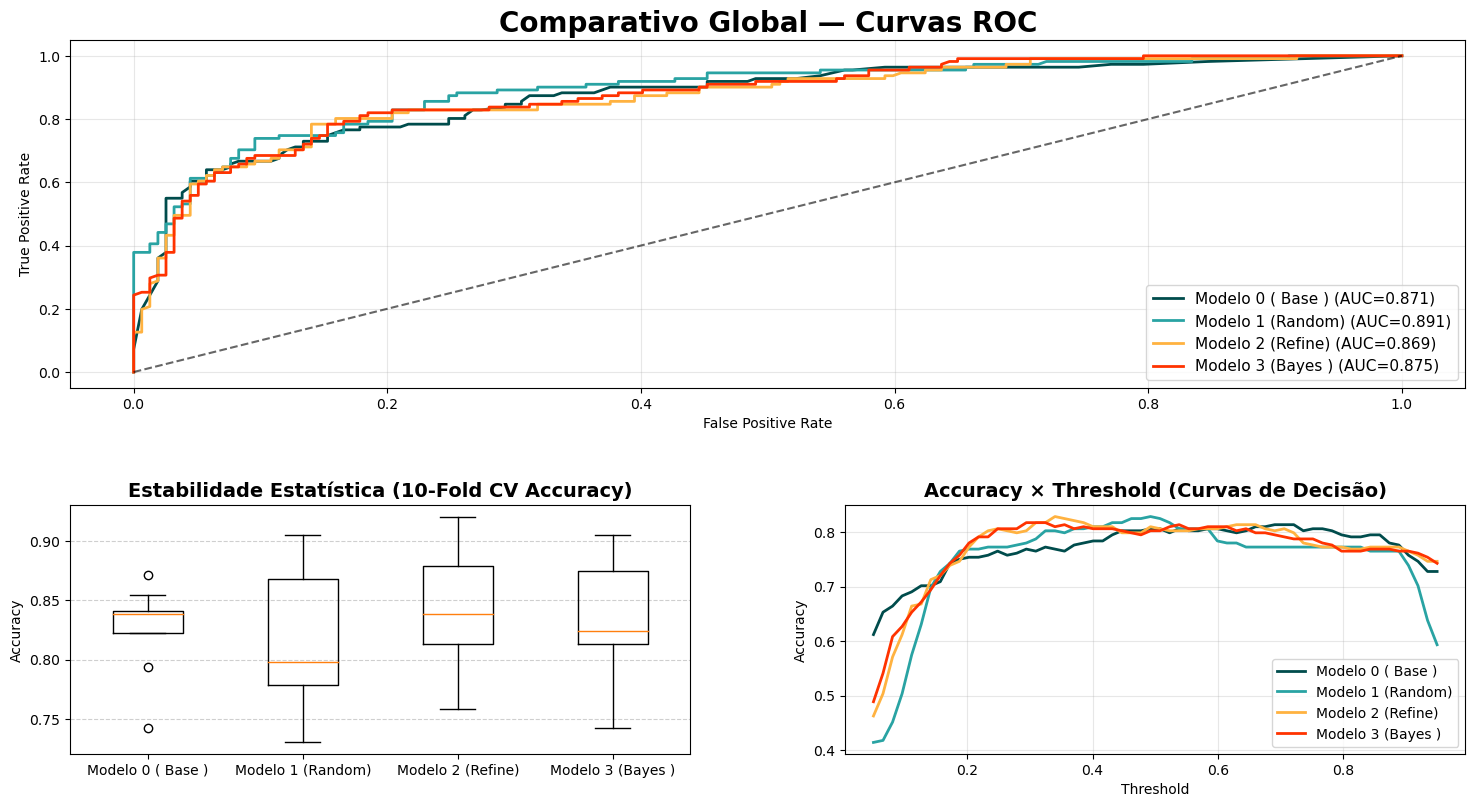

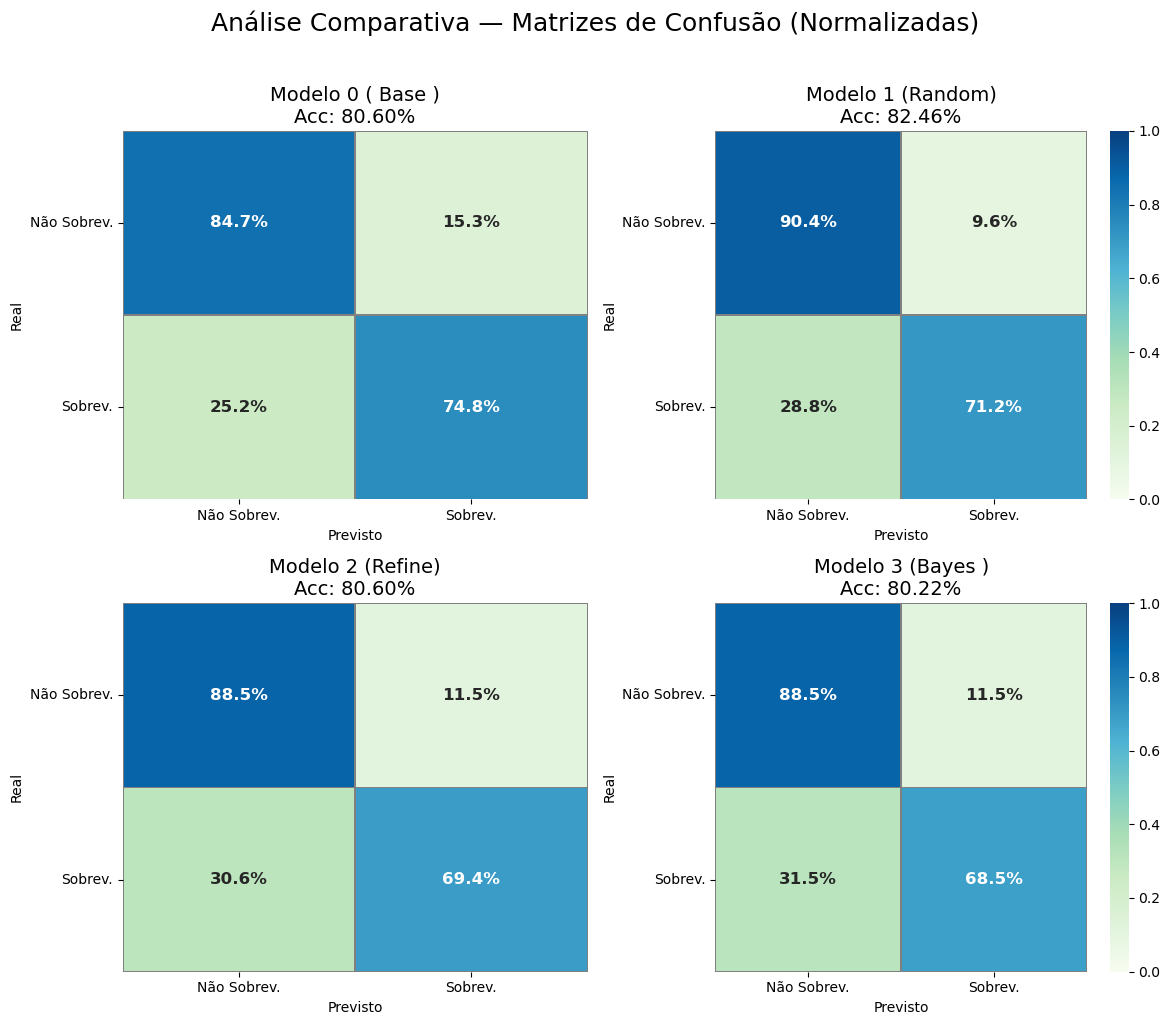

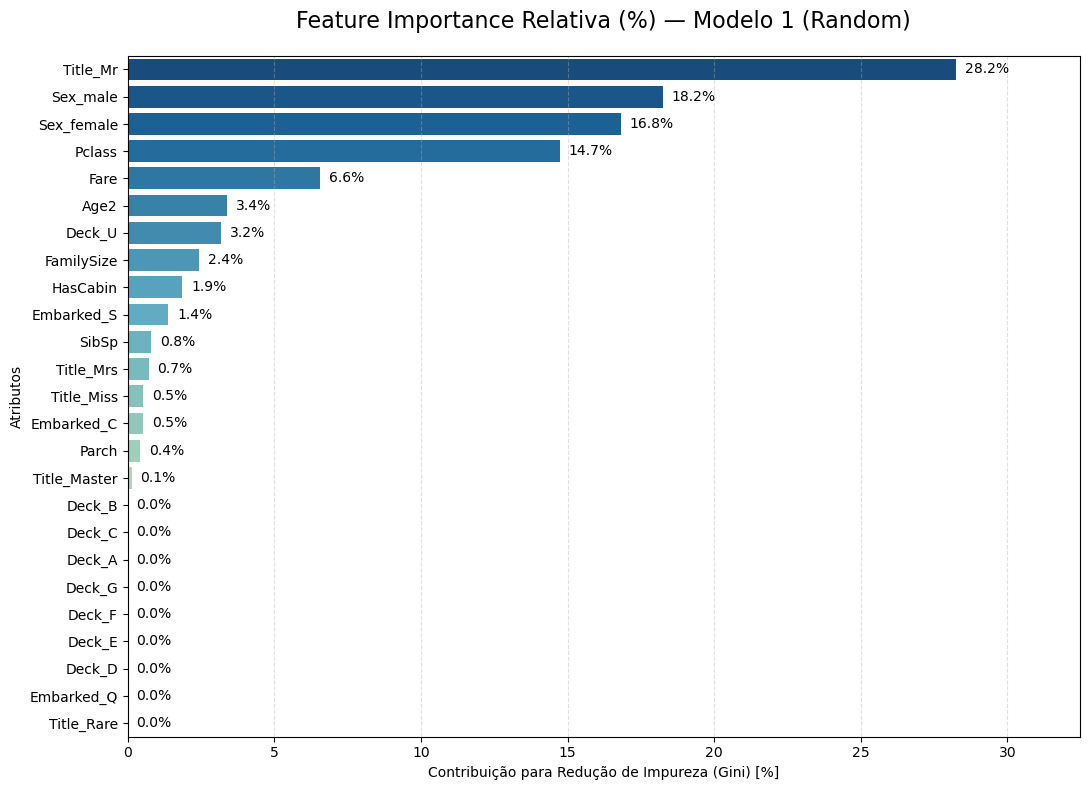


#Processo finalizado em: 16:29:07


In [8]:
#plotagem dos resultados
importances=model_evaluation_grid(
    models_list=models_list,
    X_test=X_test,
    y_test=y_test,
    best_model_pipeline=W[1],
    best_model_name=W[0]
)

## Considerações finais

A análise dos resultados evidencia de forma clara o impacto da otimização de hiperparâmetros e do ajuste de threshold no desempenho e na capacidade de generalização dos modelos Random Forest aplicados ao problema de classificação do Titanic.

### Síntese dos resultados

* O Random Forest Baseline apresentou desempenho sólido, com ROC-AUC ≈ 0.86 em validação cruzada, servindo como uma referência robusta e estável. No entanto, sua acurácia em teste permaneceu limitada, indicando espaço para melhorias no equilíbrio entre sensibilidade e especificidade.

* Os modelos otimizados apresentaram ganhos relevantes:

  * O Modelo 1 (Random Search) destacou-se como o melhor modelo global, alcançando ROC-AUC em teste de 0.8905 e acurácia otimizada de 0.8358, superando o baseline de forma consistente.

  * Os modelos Refine e Bayes obtiveram desempenhos competitivos em validação cruzada, mas não conseguiram traduzir esses ganhos de forma equivalente no conjunto de teste.

### Análise de generalização (validação cruzada)

A comparação entre ROC-AUC médio e seu desvio padrão indica que:

* O Modelo 1 (Random Search) oferece o melhor compromisso entre desempenho médio e estabilidade, com ganhos estatisticamente significativos em relação aos demais modelos otimizados;

* Modelos com maior complexidade não apresentaram melhorias proporcionais, sugerindo retornos decrescentes da otimização excessiva;

* Diferenças moderadas entre validação cruzada e teste indicam leve sensibilidade à amostragem, típica de modelos baseados em árvores.

### Interpretação e relevância das variáveis

A análise de importância das features mostra que o modelo captura padrões alinhados ao conhecimento do domínio, com destaque para:

* Título social (Mr, Mrs, Miss) e Sexo, como principais determinantes da sobrevivência;
* Classe socioeconômica (Pclass) e Tarifa (Fare) reforçando o viés estrutural do desastre;
* Variáveis familiares e de cabine contribuindo de forma secundária, mas consistente.

### Conclusões práticas

* O Random Forest com Random Search é o modelo mais indicado para este problema, combinando melhor desempenho em teste, threshold equilibrado e boa interpretabilidade relativa.

* O ajuste de threshold mostrou-se fundamental para ganhos reais de acurácia, reforçando a importância de decisões além do default 0.5.

* O baseline permanece relevante como referência, mas a otimização controlada demonstra ganhos concretos sem comprometer a estabilidade.

Esse conjunto de resultados reforça a importância de avaliar desempenho, estabilidade estatística e decisão operacional de forma integrada, especialmente em problemas de classificação com impacto prático direto.
